In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, matthews_corrcoef, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Charger le fichier
data = pd.read_csv('data/revenus.csv')

# Afficher les premières lignes et un résumé des données
print(data.info())
print(data.head())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None
   age  workclass  fnlwgt     education  educational-num      marital-s

In [39]:
# Remplacer les valeurs '?' par des valeurs manquantes (NaN)
data_cleaned = data.replace('?', pd.NA)

# Vérifier les valeurs manquantes
missing_values = data_cleaned.isnull().sum()

# Calculer le pourcentage de valeurs manquantes
missing_percentage = (missing_values / len(data_cleaned)) * 100

# Résumer les valeurs manquantes
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print(missing_summary)

# Supprimer la colonne 'fnlwgt'
data_cleaned = data_cleaned.drop(columns=['fnlwgt'])

                 Missing Values  Percentage
age                           0    0.000000
workclass                  2799    5.730724
fnlwgt                        0    0.000000
education                     0    0.000000
educational-num               0    0.000000
marital-status                0    0.000000
occupation                 2809    5.751198
relationship                  0    0.000000
race                          0    0.000000
gender                        0    0.000000
capital-gain                  0    0.000000
capital-loss                  0    0.000000
hours-per-week                0    0.000000
native-country              857    1.754637
income                        0    0.000000


In [40]:
# Step 1: Encode categorical columns
label_encoders = {}
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 
                       'relationship', 'race', 'gender', 'native-country', 'income']

for column in categorical_columns:
    le = LabelEncoder()
    # Remplacer NaN temporairement pour appliquer l'encodage
    data_cleaned[column] = data_cleaned[column].fillna('Missing')
    data_cleaned[column] = le.fit_transform(data_cleaned[column].astype(str))
    label_encoders[column] = le

# Step 2: Normalize numeric columns
scaler = StandardScaler()
numeric_columns = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
data_cleaned[numeric_columns] = scaler.fit_transform(data_cleaned[numeric_columns])

# Step 3: Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
data_imputed = knn_imputer.fit_transform(data_cleaned)

# Convert back to DataFrame
data_cleaned = pd.DataFrame(data_imputed, columns=data_cleaned.columns)

# Step 4: Decode categorical columns
for column in categorical_columns:
    le = label_encoders[column]
    # Convert back to int to inverse transform
    data_cleaned[column] = le.inverse_transform(data_cleaned[column].round().astype(int))

# Check for remaining NaN values
print(data_cleaned.isnull().sum())

data_cleaned.head(15)

age                0
workclass          0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64


,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,-0.995129,Private,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,-0.144804,-0.217127,-0.034087,United-States,<=50K
1,-0.046942,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,-0.144804,-0.217127,0.772930,United-States,<=50K
2,-0.776316,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,-0.144804,-0.217127,-0.034087,United-States,>50K
3,0.390683,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,0.886874,-0.217127,-0.034087,United-States,>50K
4,-1.505691,Missing,Some-college,10.0,Never-married,Missing,Own-child,White,Female,-0.144804,-0.217127,-0.841104,United-States,<=50K
5,-0.338691,Private,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,-0.144804,-0.217127,-0.841104,United-States,<=50K
6,-0.703379,Missing,HS-grad,9.0,Never-married,Missing,Unmarried,Black,Male,-0.144804,-0.217127,-0.034087,United-States,<=50K
7,1.776496,Self-emp-not-inc,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.271598,-0.217127,-0.679700,United-States,>50K
8,-1.068066,Private,Some-college,10.0,Never-married,Other-service,Unmarried,White,Female,-0.144804,-0.217127,-0.034087,United-States,<=50K
9,1.192996,Private,7th-8th,4.0,Married-civ-spouse,Craft-repair,Husband,White,Male,-0.144804,-0.217127,-2.455137,United-States,<=50K


In [41]:
# Fonction pour supprimer les valeurs aberrantes en utilisant IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filtrer les lignes en dehors des bornes
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Appliquer la méthode IQR sur chaque colonne numérique
numeric_columns = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
for column in numeric_columns:
    data_cleaned = remove_outliers_iqr(data_cleaned, column)

# Vérifier le nombre de lignes restantes après suppression des valeurs aberrantes
print(data_cleaned.shape)

(30626, 14)


In [42]:
# Fonction pour encoder les colonnes catégoriques
label_encoders = {}
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 
                       'relationship', 'race', 'gender', 'native-country', 'income']

# Encoder les colonnes catégoriques pour Isolation Forest
for column in categorical_columns:
    le = LabelEncoder()
    data_cleaned[column] = le.fit_transform(data_cleaned[column].astype(str))
    label_encoders[column] = le

# Initialiser et appliquer Isolation Forest
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
categorical_data = data_cleaned[categorical_columns]

# Prédire les anomalies (-1 indique une anomalie)
outliers = isolation_forest.fit_predict(categorical_data)

# Ajouter une colonne pour indiquer les anomalies
data_cleaned['isolation_forest_outlier'] = outliers

# Supprimer les anomalies détectées
data_no_outliers = data_cleaned[data_cleaned['isolation_forest_outlier'] != -1]

# Vérifier le nombre de lignes restantes après suppression des anomalies
print(data_no_outliers.shape)

(29094, 15)


In [43]:
# Sélectionner les features (X) et la cible (y)
X = data_no_outliers.drop(columns=['income', 'isolation_forest_outlier'])  # Features
y = data_no_outliers['income']  # Cible (0 ou 1, encodé)

# Diviser les données en ensemble d'entraînement (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner un modèle de régression logistique
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Entraîner un arbre de décision
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Prédictions des deux modèles
y_pred_log_reg = log_reg.predict(X_test)
y_pred_tree = decision_tree.predict(X_test)

# Probabilités pour le calcul de l'AUC
y_prob_log_reg = log_reg.predict_proba(X_test)[:, 1]
y_prob_tree = decision_tree.predict_proba(X_test)[:, 1]

In [44]:
# Calcul des métriques pour la régression logistique
auc_log_reg = roc_auc_score(y_test, y_prob_log_reg)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)
mcc_log_reg = matthews_corrcoef(y_test, y_pred_log_reg)

# Calcul des métriques pour l'arbre de décision
auc_tree = roc_auc_score(y_test, y_prob_tree)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)
mcc_tree = matthews_corrcoef(y_test, y_pred_tree)

# Résumer les résultats dans un tableau
model_comparison = pd.DataFrame({
    'Metric': ['AUC', 'Accuracy', 'F1 Score', 'MCC'],
    'Logistic Regression': [auc_log_reg, accuracy_log_reg, f1_log_reg, mcc_log_reg],
    'Decision Tree': [auc_tree, accuracy_tree, f1_tree, mcc_tree]
})

print(model_comparison)

     Metric  Logistic Regression  Decision Tree
0       AUC             0.818660       0.706920
1  Accuracy             0.828149       0.791889
2  F1 Score             0.406176       0.450794
3       MCC             0.344247       0.322528


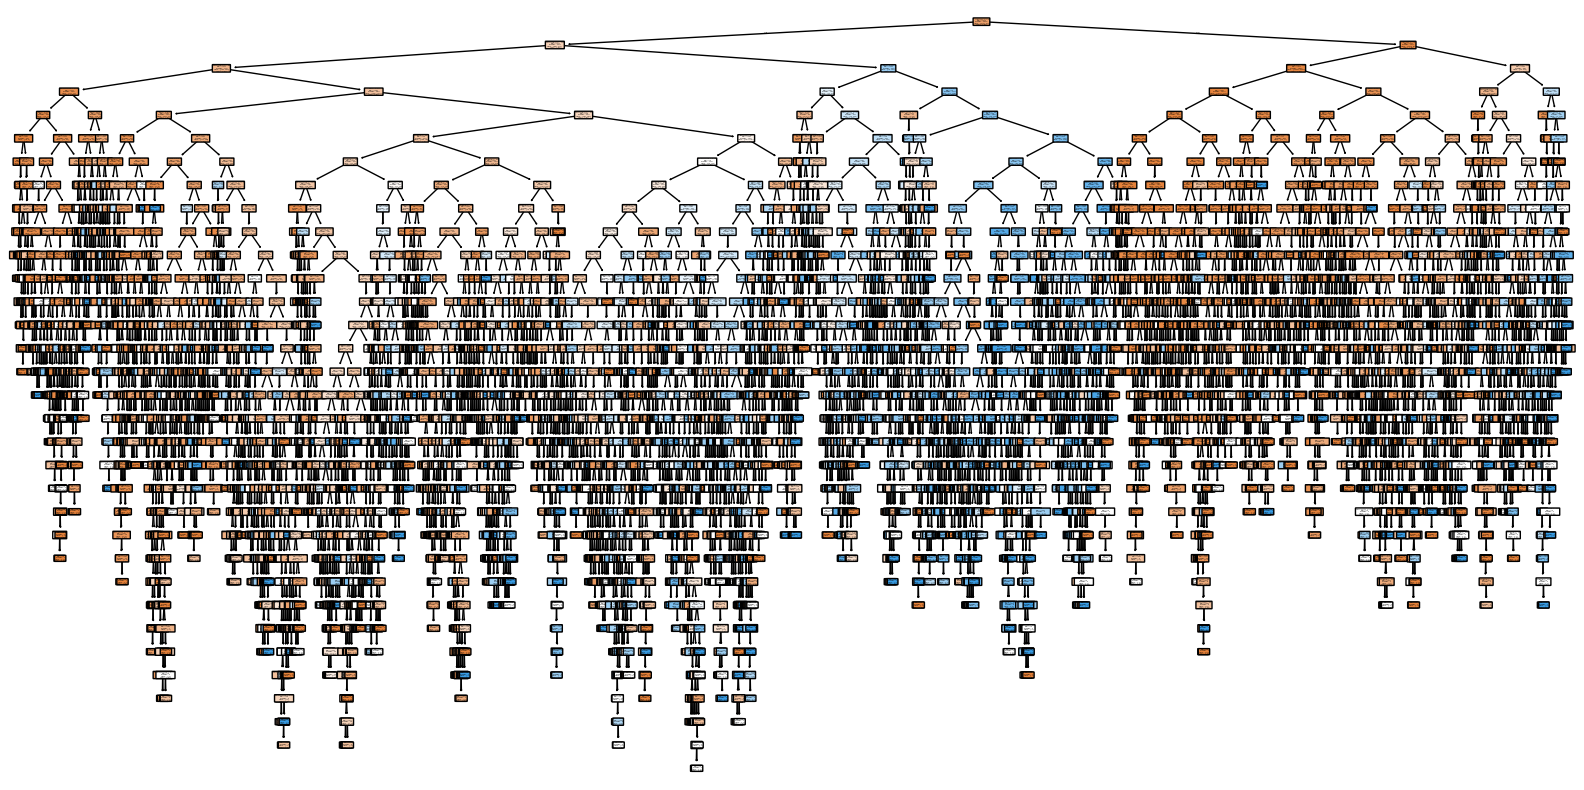

In [45]:
# Affichage de l'arbre de décision
plt.figure(figsize=(20,10))
plot_tree(decision_tree, feature_names=X.columns, class_names=['<=50K', '>50K'], filled=True, rounded=True)
plt.show()

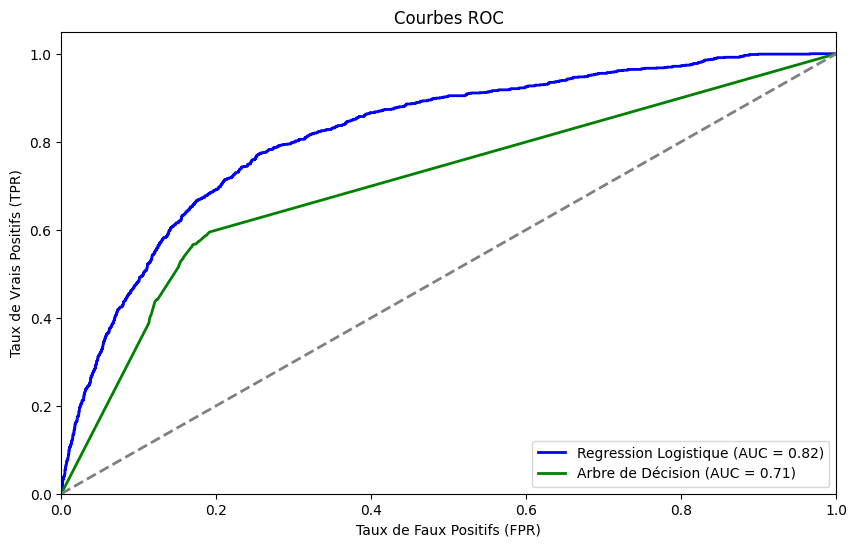

In [46]:
# Générer la courbe ROC pour les deux modèles
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_prob_log_reg)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)

# Calcul des AUC pour les courbes ROC
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
roc_auc_tree = auc(fpr_tree, tpr_tree)

# Tracer les courbes ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_log_reg, tpr_log_reg, color='blue', lw=2, label=f'Regression Logistique (AUC = {roc_auc_log_reg:.2f})')
plt.plot(fpr_tree, tpr_tree, color='green', lw=2, label=f'Arbre de Décision (AUC = {roc_auc_tree:.2f})')

# Ajouter des étiquettes et des légendes
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC')
plt.legend(loc='lower right')
plt.show()

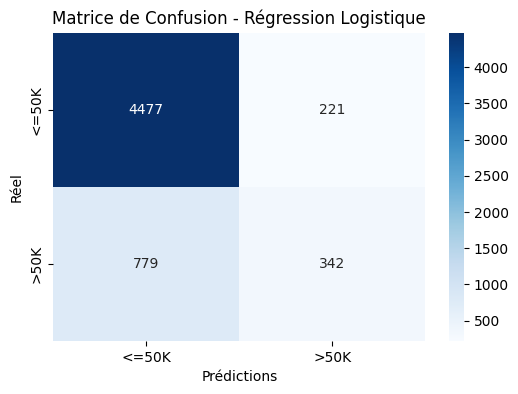

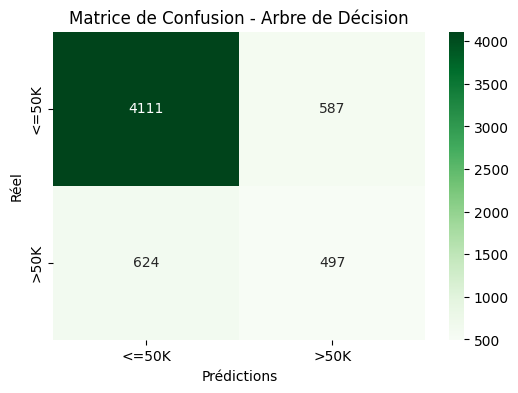

In [47]:
# Générer et afficher la matrice de confusion pour la régression logistique
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt="d", cmap="Blues", xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.title('Matrice de Confusion - Régression Logistique')
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()

# Générer et afficher la matrice de confusion pour l'arbre de décision
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_tree, annot=True, fmt="d", cmap="Greens", xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.title('Matrice de Confusion - Arbre de Décision')
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()

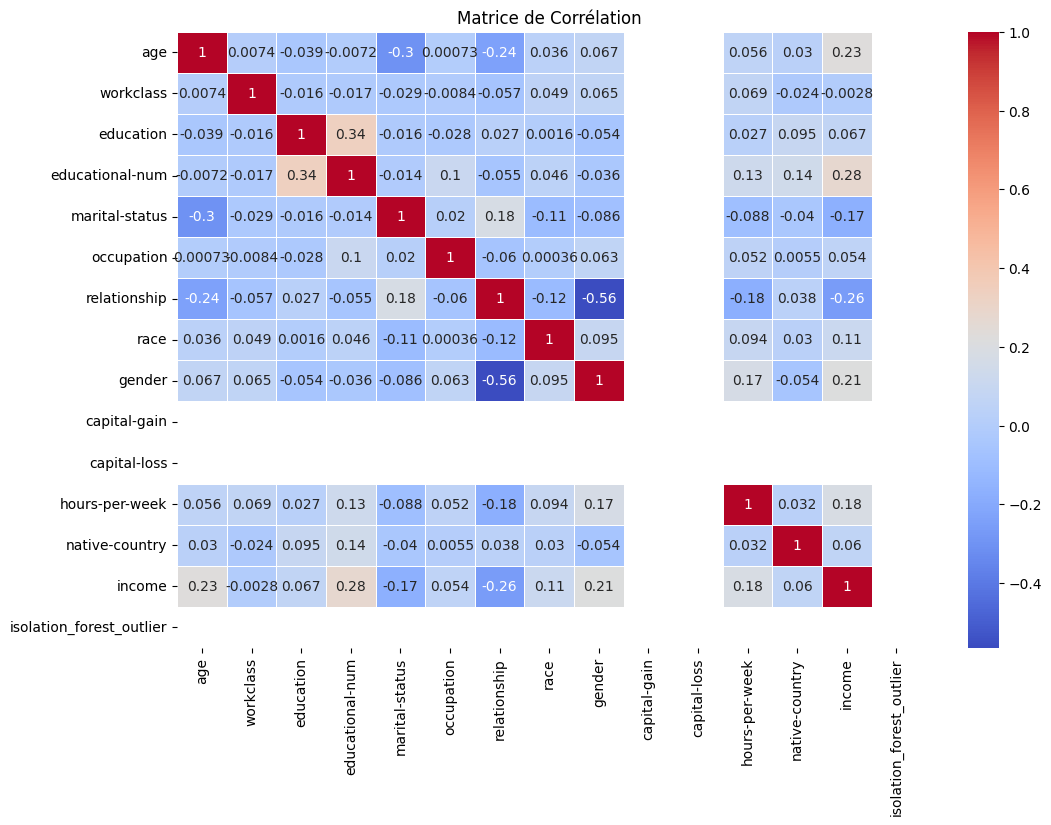

In [48]:
corr_matrix = data_no_outliers.corr()

# Afficher la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()